# Package Calling

In [1]:
import sys

sys.path.append("../../")

In [2]:
import datetime as dtt
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Package Settings

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [183]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("chained_assignment", None)

In [146]:
plt.rcParams["font.family"] = ["Arial Unicode MS"]  # Chinese Labels
plt.rcParams["axes.unicode_minus"] = False  # Minus Sign

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (12, 6),
        "font.sans-serif": ["Arial Unicode MS", "Arial"],
    },
)

## GC Settings

In [6]:
import gc

gc.isenabled()
gc.get_threshold()

True

(700, 10, 10)

In [7]:
# gc.set_threshold(10,1,1)
# gc.enable()
# gc.disable()

# Modeling

In [190]:
data_path = "/Users/chenzhou/Documents/Everything/python/COVID19/data/data_0516_SH.csv"
data_sh = pd.read_csv(
    data_path,
    dtype={
        "inbound_confirmed": int,
        "inbound_asymp": int,
        "outbound_confirmed": int,
        "outbound_asymp": int,
        "cure": int,
        "relieve": int,
    },
    parse_dates=["date"],
)

In [191]:
data_sh["confirmed_add"] = data_sh.inbound_confirmed + data_sh.outbound_confirmed
data_sh["asymp_add"] = data_sh.inbound_asymp + data_sh.outbound_asymp
data_sh["total_add"] = data_sh.confirmed_add + data_sh.asymp_add

data_sh["confirmed_acc"] = data_sh.confirmed_add.cumsum() - 380
data_sh["asymp_acc"] = data_sh.asymp_add.cumsum() - 120
data_sh["total_affected"] = data_sh.confirmed_acc + data_sh.asymp_acc

data_sh = data_sh.loc[data_sh.date >= "2022-03-01"].reset_index(drop=True)

In [192]:
data_sh

,inbound_confirmed,inbound_asymp,outbound_confirmed,outbound_asymp,date,cure,relieve,confirmed_add,asymp_add,total_add,confirmed_acc,asymp_acc,total_affected
0,1,1,37,17,2022-03-01,8,1,38,18,56,95,5,100
1,3,5,39,19,2022-03-02,8,2,42,24,66,137,29,166
2,2,14,43,21,2022-03-03,9,1,45,35,80,182,64,246
3,3,16,24,10,2022-03-04,12,0,27,26,53,209,90,299
4,0,28,25,10,2022-03-05,8,4,25,38,63,234,128,362
5,3,45,32,16,2022-03-06,65,16,35,61,96,269,189,458
6,4,51,36,10,2022-03-07,27,10,40,61,101,309,250,559
7,3,62,26,10,2022-03-08,32,7,29,72,101,338,322,660
8,4,76,42,16,2022-03-09,18,13,46,92,138,384,414,798
9,11,64,32,10,2022-03-10,17,7,43,74,117,427,488,915


## Optimize BS Pars Locally

In [222]:
from skfda.representation.basis import BSpline

In [235]:
def bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    early_stop_ratio,
    early_stop_steps,
    show_process,
):
    # define interp
    x = range(len(ser))
    knots = np.linspace(0, len(ser) - 1, round(bs_interp_prop * (len(ser) - 1) + 1))
    integ_x = np.linspace(
        0, len(ser) - 1, round(interg_interp_prop * (len(ser) - 1) + 1)
    )
    # define bs funcs
    bs_func = BSpline(domain_range=(min(x), max(x)), order=4, knots=knots)
    bs_func_d = bs_func.derivative()
    # obtain interpped bs rst
    bS = bs_func(x).squeeze(2)
    bs_integ = bs_func(integ_x).squeeze(2)
    bs_partial = bs_func_d(integ_x).squeeze(2)
    # construct diff features
    shift_ = round(tau * interg_interp_prop)
    now_bs_integ = bs_integ[:, shift_:]
    delay_bs_integ = bs_integ[:, :-shift_]
    now_bs_partial = bs_partial[:, shift_:]
    delay_bs_partial = bs_partial[:, :-shift_]
    # initialize parameters
    n_coeff = bS.shape[0]
    init_coeff = np.repeat(0, n_coeff)
    init_grad = np.repeat(0, n_coeff)

    loss_update = []
    losses = [np.inf]
    continuous_remain = 0
    for _iter in range(iters):
        # loss calculation
        loglik_loss_vec = np.dot(init_coeff, bS) - ser
        loglik_loss = np.linalg.norm(loglik_loss_vec, 2)
        mat_ = now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ
        integ_loss_vec = np.dot(init_coeff, mat_)
        integ_loss = (
            np.linalg.norm(integ_loss_vec, 2) / np.sqrt(interg_interp_prop) * labd
        )
        loss_ = loglik_loss + integ_loss

        if (
            loss_ == np.inf
            or loss_ / min(losses) > early_stop_ratio[0]
            or continuous_remain > early_stop_steps
        ):
            break
        if loss_ / min(losses) >= early_stop_ratio[1]:
            continuous_remain = np.clip(continuous_remain + 1, 0, np.inf)
        else:
            continuous_remain = 0

        # gradient descent
        loglik_part = np.dot(bS, loglik_loss_vec)
        integ_part = (
            np.dot(mat_, np.dot(init_coeff, mat_)) / interg_interp_prop * labd**2
        )
        init_coeff = init_coeff - lr * (loglik_part + integ_part)
        lr *= decay
        losses.append(loss_)
        if show_process:
            # print(
            #     "loglik: {} integ: {}".format(
            #         loglik_loss / np.sqrt(len(ser)),
            #         integ_loss / labd / np.sqrt(len(ser)),
            #     )
            # )
            loss_update.append(
                [
                    _iter,
                    loglik_loss / np.sqrt(len(ser)),
                    integ_loss / labd / np.sqrt(len(ser)),
                ]
            )

    coef_mat = np.dot(bS, bS.T) + np.dot(mat_, mat_.T) / interg_interp_prop * labd**2
    k_mat = np.dot(
        np.dot(
            now_bs_integ - mu * delay_bs_integ,
            (now_bs_integ - mu * delay_bs_integ - now_bs_partial).T,
        ),
        init_coeff,
    )
    m_mat = np.dot(
        (mu * kappa**2) * np.dot(delay_bs_integ, delay_bs_integ.T)
        + kappa * np.dot(delay_bs_integ, (now_bs_partial - kappa * now_bs_integ).T),
        init_coeff,
    )
    t_mat = -np.dot(
        (
            2
            * kappa
            * mu
            * np.dot(
                now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ,
                delay_bs_partial.T,
            )
            + (now_bs_partial - kappa * now_bs_integ + kappa * mu * delay_bs_integ)[
                :, [0]
            ]
            ** 2
        ),
        init_coeff,
    )
    partial_resid_theta = (
        np.dot(np.dot(bS.T, np.linalg.inv(coef_mat)), np.array([k_mat, m_mat, t_mat]).T)
        * 2
        * labd**2
        / interg_interp_prop
    )
    theta_grad = np.dot(
        np.dot(
            np.linalg.inv(
                np.dot(partial_resid_theta.T, partial_resid_theta).astype(np.float)
            ),
            partial_resid_theta.T,
        ),
        ser - np.dot(bS.T, init_coeff),
    )
    fitted_ser = np.dot(bS.T, init_coeff)
    if show_process:
        f, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.scatterplot(x=x, y=ser, alpha=1.0, color="blue", s=15, ax=axes[0])
        sns.lineplot(
            x=integ_x,
            y=np.dot(bs_integ.T, init_coeff),
            alpha=0.8,
            color="yellow",
            ax=axes[0],
        )

        loss_df = pd.DataFrame(
            loss_update, columns=["iter", "loglik_loss", "integ_loss"]
        )
        ax = sns.lineplot(
            data=loss_df, x="iter", y="loglik_loss", color="green", ax=axes[1]
        )
        ax2 = ax.twinx()
        sns.lineplot(data=loss_df, x="iter", y="integ_loss", color="red", ax=ax2)
    return theta_grad, loss_, fitted_ser

In [236]:
bs_interp_prop = 0.5
interg_interp_prop = 500.0
ser = data_sh.total_affected.iloc[28:].values
kappa, mu, tau = 0.6, 1.0, 1.8

In [239]:
labd, lr, decay, iters, early_stop_ratio, early_stop_steps, show_process = (
    5.0,
    0.02,
    0.999,
    int(4e2),
    [1.1, 0.999],
    3,
    True,
)

(array([ 0.01334058, -0.00412426, -0.01524859]),
 71287.32574829267,
 array([ 23716.50227192,  29267.57759361,  36263.64701659,  44295.02733051,
         53767.17268993,  65222.33247905,  78934.79963574,  95050.87891611,
        113472.87879545, 134002.79553881, 156285.37285089, 179917.71561156,
        204463.6259618 , 229489.34554713, 254604.17677027, 279446.68932791,
        303729.46133524, 327221.10105283, 349840.32890407, 371567.26061194,
        392477.48093494, 412683.55166959, 432350.47372884, 451592.91974656,
        470271.81012383, 488150.47378133, 504855.62595107, 520037.98826662,
        533580.92165638, 545464.00244507, 555819.02924771, 564814.93542426,
        572616.97102387, 579390.88574322, 585308.11117974, 590532.90367277,
        595195.13662839, 599400.20759473, 603189.9936213 , 606576.52740345,
        609515.98471857, 611961.70311122, 613911.5241125 , 615378.37820116,
        616391.04765972, 616990.10285834, 617247.41471378, 617269.16300156,
        617267.4623

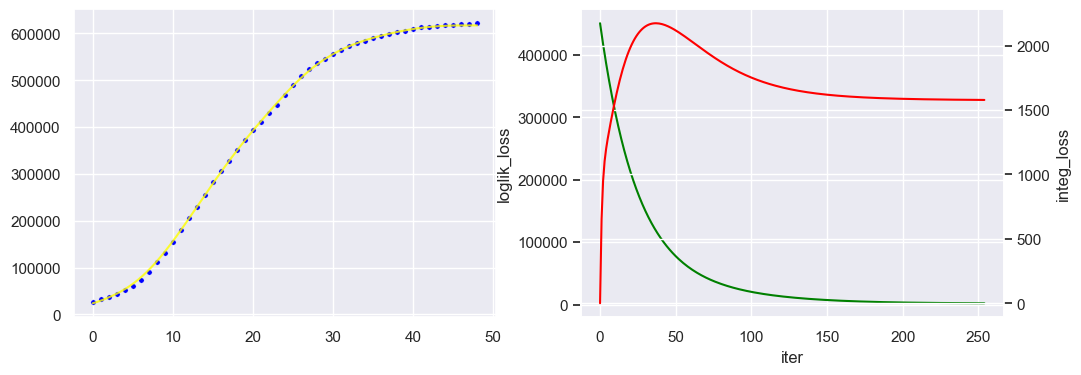

In [240]:
bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    early_stop_ratio,
    early_stop_steps,
    show_process,
)

## Optimize Theta Globally

In [259]:
def model_theta_global_opt(
    ser,
    kappa_init,
    mu_init,
    tau_init,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    bs_lr_schedule,
    theta_lr_schedule,
    early_stop_ratio,
    early_stop_steps,
    show_process="outer",
):
    losses = [np.inf]
    theta = np.array([kappa_init, mu_init, tau_init])
    theta_selected = theta.copy()
    iters_bs, lr_bs, decay_bs = bs_lr_schedule
    iters_theta, lr_theta, decay_theta = theta_lr_schedule

    if show_process == "outer":
        show_process_bs, show_process_theta = False, True
    elif show_process == "inner":
        show_process_bs, show_process_theta = True, False
    elif show_process == "both":
        show_process_bs, show_process_theta = True, True
    else:
        show_process_bs, show_process_theta = False, False

    continuous_remain = 0
    for iter_theta_ in range(iters_theta):
        theta_grad, loss_, fitted_ser = bs_coeff_local_opt(
            ser,
            theta[0],
            theta[1],
            theta[2],
            bs_interp_prop,
            interg_interp_prop,
            labd,
            lr_bs,
            decay_bs,
            iters_bs,
            early_stop_ratio,
            early_stop_steps,
            show_process_bs,
        )
        if (
            loss_ == np.inf
            or loss_ / min(losses) > early_stop_ratio[0]
            or continuous_remain > early_stop_steps
        ):
            break
        if loss_ / min(losses) >= early_stop_ratio[1]:
            continuous_remain = np.clip(continuous_remain + 1, 0, np.inf)
        else:
            continuous_remain = 0

        if min(losses) > loss_:
            theta_selected = theta.copy()
            fitted_ser_selected = fitted_ser.copy()

        theta[0] -= lr_theta * theta_grad[0]
        theta[1] -= lr_theta * theta_grad[1]
        theta[2] -= lr_theta * theta_grad[2]

        lr_theta = lr_theta * decay_theta
        losses.append(loss_)
        if show_process_theta:
            print("inter {}: Theta: {} Loss: {}".format(iter_theta_, theta, loss_))
    if show_process_theta:
        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(x=range(len(losses)), y=losses)
        ax = sns.scatterplot(x=range(len(losses)), y=losses)
    return theta_selected, losses, fitted_ser_selected

In [276]:
kappa_init, mu_init, tau_init = 0.59, 1.0, 1.81

inter 0: Theta: [0.58877098 1.00050465 1.81161367] Loss: 66548.91826790915
inter 1: Theta: [0.58764416 1.00118792 1.81321259] Loss: 63103.84986855966
inter 2: Theta: [0.5866601  1.00222007 1.81479636] Loss: 59000.69222594681
inter 3: Theta: [0.5859113  1.00410778 1.81638125] Loss: 53662.40613628849
inter 4: Theta: [0.58543407 1.00775404 1.81805857] Loss: 49790.274882980215


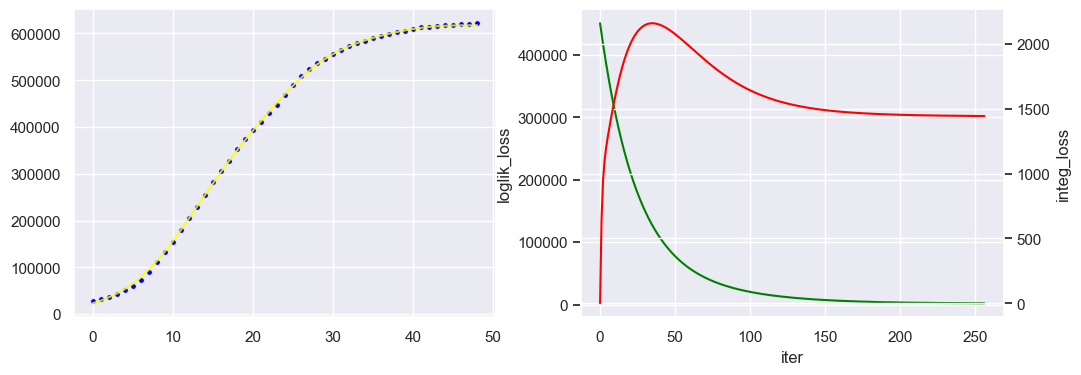

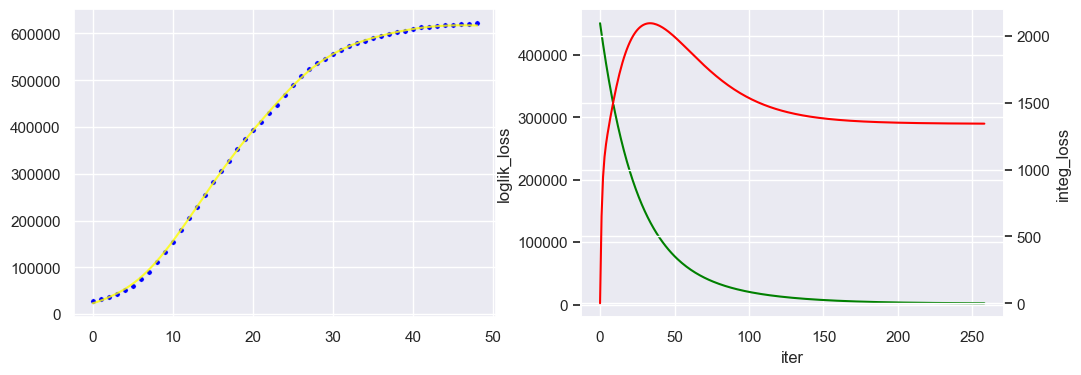

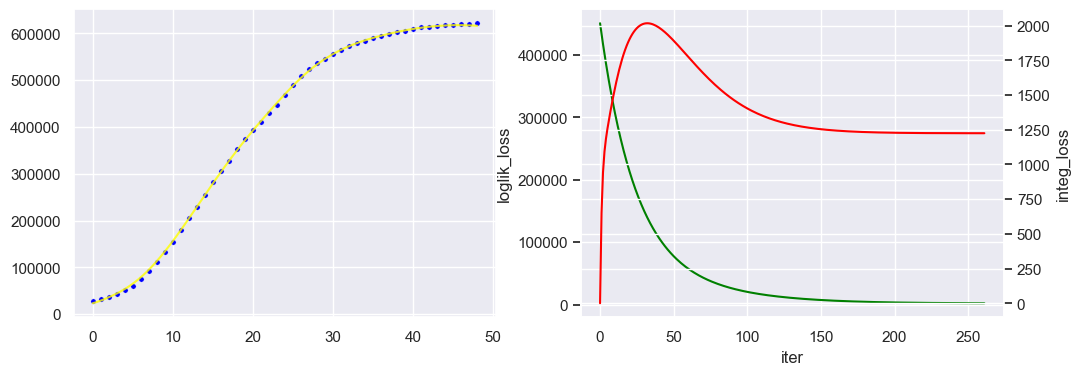

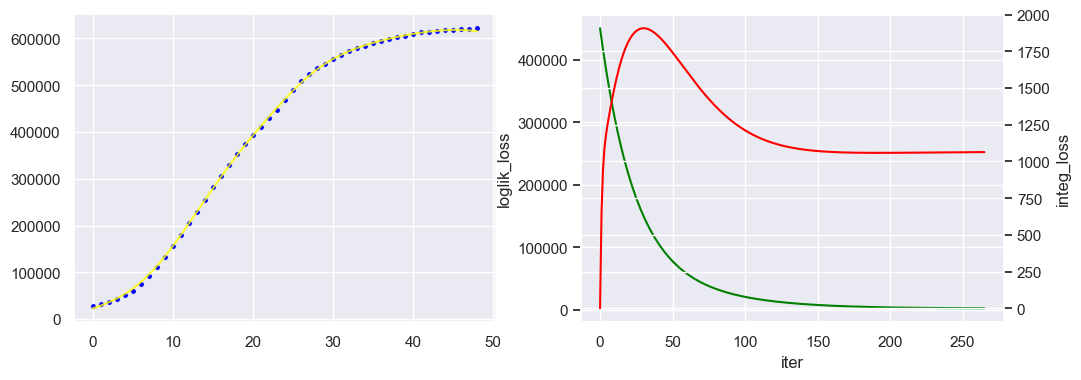

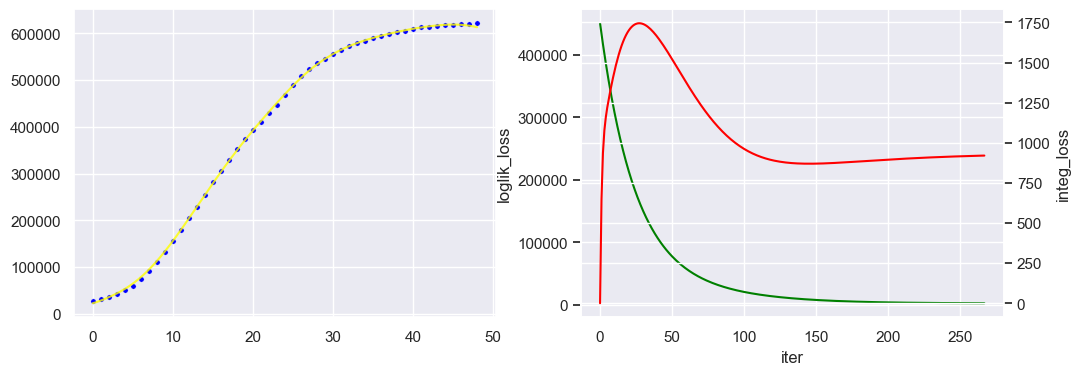

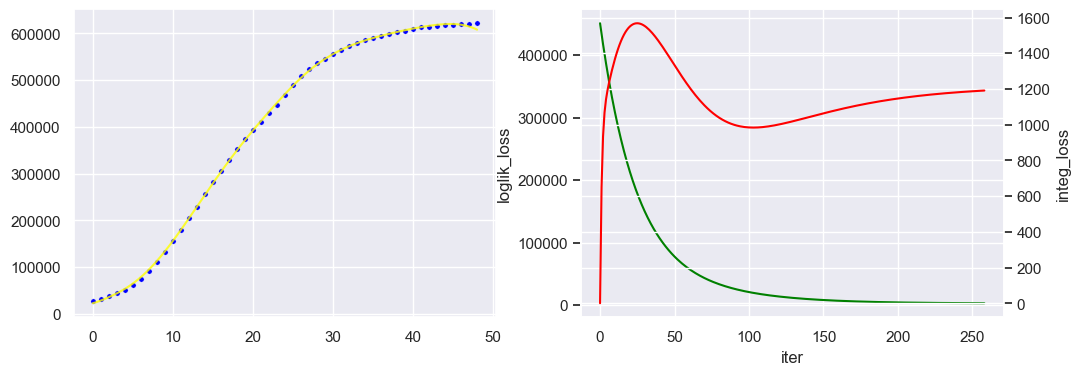

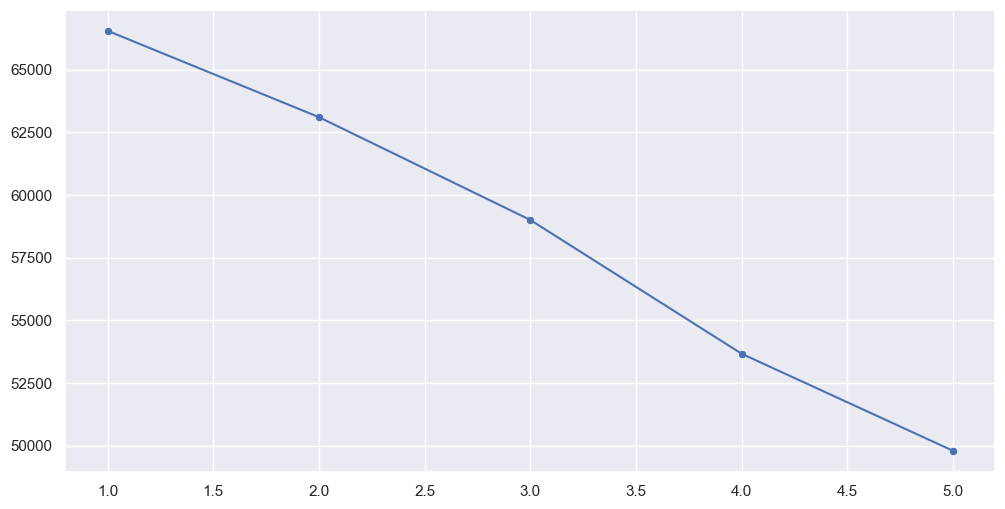

In [277]:
ser = data_sh.total_affected.iloc[28:].values

theta_opt, losses, fitted_opt = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.1, 0.99),
    early_stop_ratio=[1.2, 0.999],
    early_stop_steps=3,
    show_process="both",
)

<AxesSubplot:>

<AxesSubplot:>

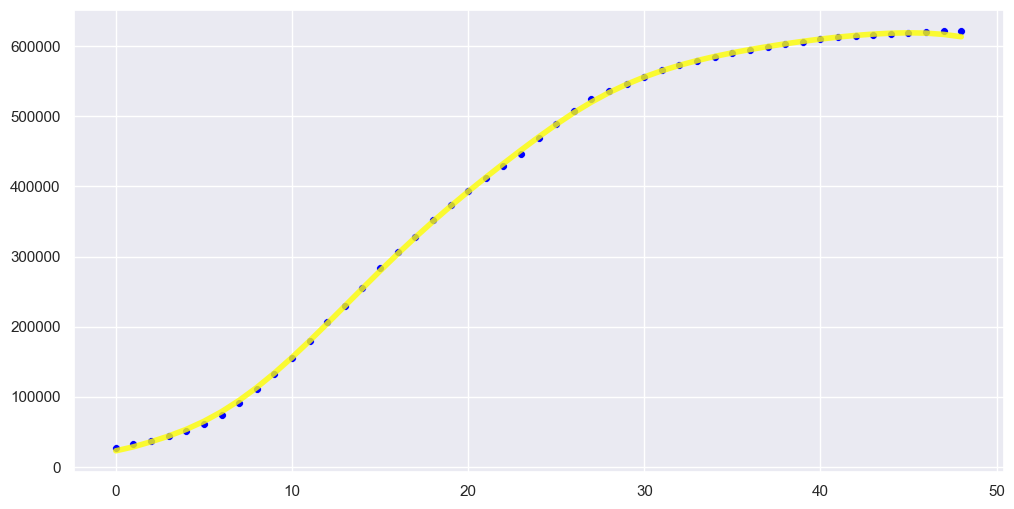

In [278]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(x=range(len(ser)), y=fitted_opt, alpha=0.8, color="yellow", linewidth=4)

# Application on SZ

In [264]:
data_sz = pd.read_csv(
    "/Users/chenzhou/Documents/Everything/python/COVID19/data/covid19_shenzhen.csv",
    dtype={
        "week_group": int,
        "adt": int,
        "imputed_adt": float,
        "adt_prop": float,
        "store_cnt": int,
        "cfm_cases": pd.Int64Dtype(),
        "asym_cases": pd.Int64Dtype(),
        "covid_group": int,
    },
    parse_dates=["date"],
)
# data_sz.fillna(0, inplace=True)
data_sz["total_add"] = data_sz.cfm_cases + data_sz.asym_cases

In [286]:
data_modeling = data_sz.loc[data_sz.covid_group.eq(2)]
shifting = 0
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting

In [287]:
data_modeling

,date,week_group,adt,imputed_adt,adt_prop,store_cnt,cfm_cases,asym_cases,covid_group,total_add,total_affected
1161,2022-03-07,166,5559,5559.000,1.000,238,19,0,2,19,19
1162,2022-03-08,166,7257,7257.000,1.000,235,13,0,2,13,32
1163,2022-03-09,166,6194,6194.000,1.000,236,6,0,2,6,38
1164,2022-03-10,166,6484,6484.000,1.000,239,15,0,2,15,53
1165,2022-03-11,166,6309,6309.000,1.000,241,9,2,2,11,64
1166,2022-03-12,166,3101,9998.623,0.310,233,27,2,2,29,93
1167,2022-03-13,166,1700,9658.631,0.176,213,60,6,2,66,159
1168,2022-03-14,167,698,7530.603,0.093,182,75,11,2,86,245
1169,2022-03-15,167,463,7776.377,0.060,162,39,21,2,60,305
1170,2022-03-16,167,161,7867.639,0.020,102,55,37,2,92,397


(array([0.019520461669545134, -0.02482295931279995, -0.019725080566658486],
       dtype=object),
 234.25936581542396,
 array([0.37622746613772834, 16.956809353689195, 35.25246648184783,
        56.52945706713193, 85.40707770137351, 125.97468759194228,
        179.5658275553068, 245.86958539726552, 322.28029712951684,
        405.3988106471902, 491.0151786887819, 574.1787271056181,
        649.2700949032229, 712.4509147535241, 761.6578557060161,
        796.9254648349815, 819.8027235716542, 832.6822446738382,
        838.3765214558086, 839.5191874154675, 838.557962579865,
        837.3731394403324], dtype=object))

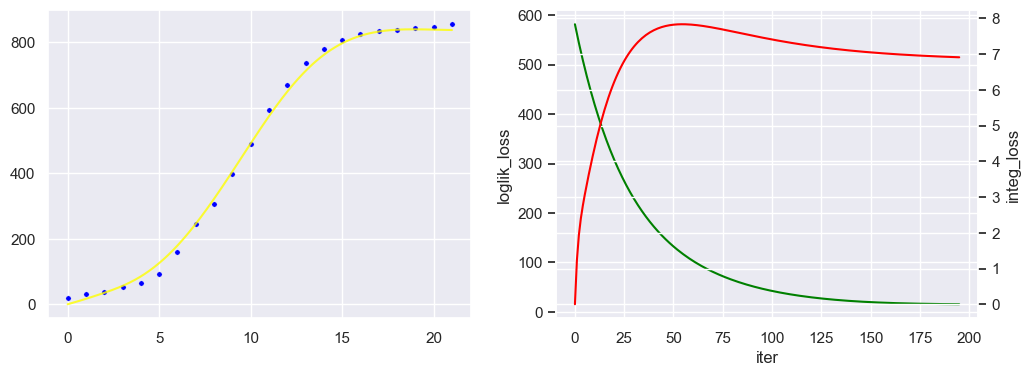

In [288]:
ser = data_modeling.total_affected.iloc[:].values
kappa_init, mu_init, tau_init = 0.7, 1.0, 1.3

bs_coeff_local_opt(
    ser,
    kappa=kappa_init,
    mu=mu_init,
    tau=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    lr=0.02,
    decay=0.999,
    iters=int(4e2),
    early_stop_ratio=[1.2, 0.999],
    early_stop_steps=3,
    show_process=True,
)

inter 0: Theta: [0.70001678 1.00708625 1.29733679] Loss: 244.11682976761395
inter 1: Theta: [0.69982523 1.00723698 1.29755069] Loss: 244.7508236832866
inter 2: Theta: [0.69964757 1.00739353 1.29776396] Loss: 242.4116301407028
inter 3: Theta: [0.69947339 1.00754703 1.2979758 ] Loss: 243.03435349212054
inter 4: Theta: [0.69930267 1.00769759 1.29818622] Loss: 243.655045880167
inter 5: Theta: [0.6991354  1.00784531 1.29839522] Loss: 244.27334145970968
inter 6: Theta: [0.69897156 1.0079903  1.2986028 ] Loss: 244.8889082416551


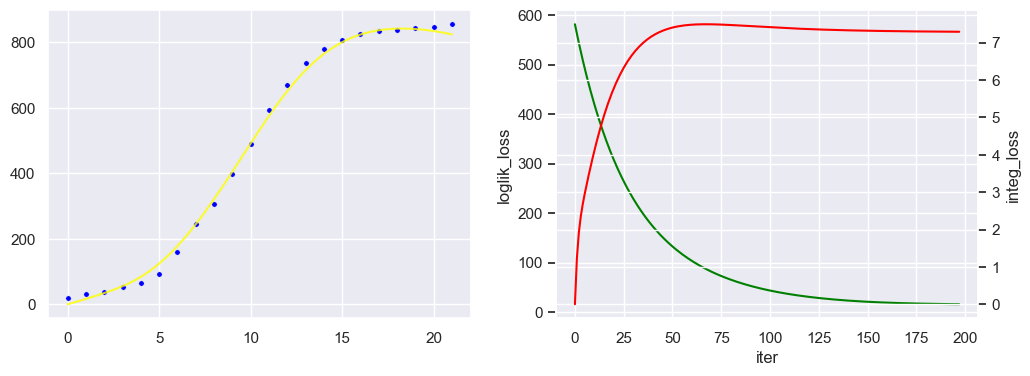

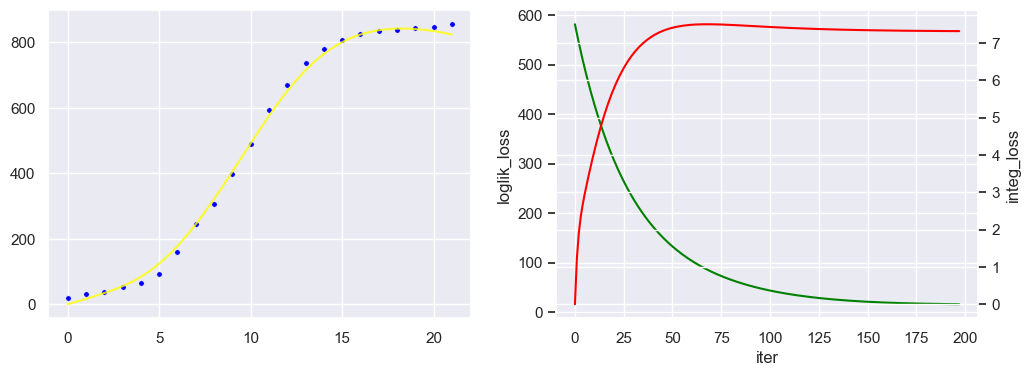

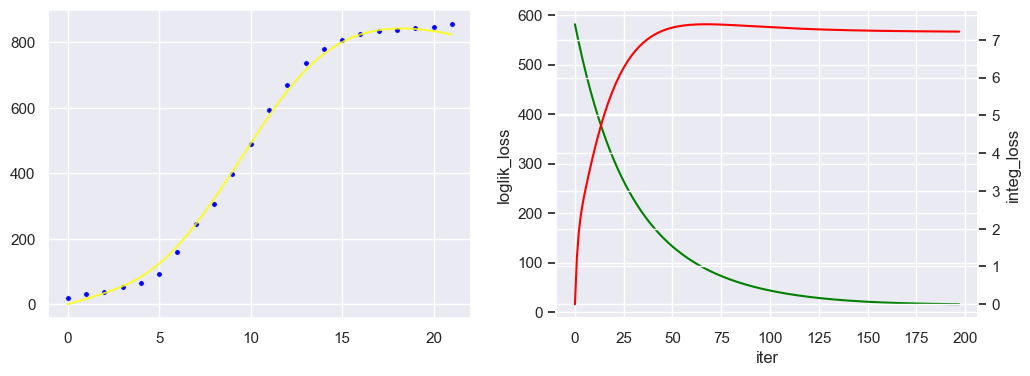

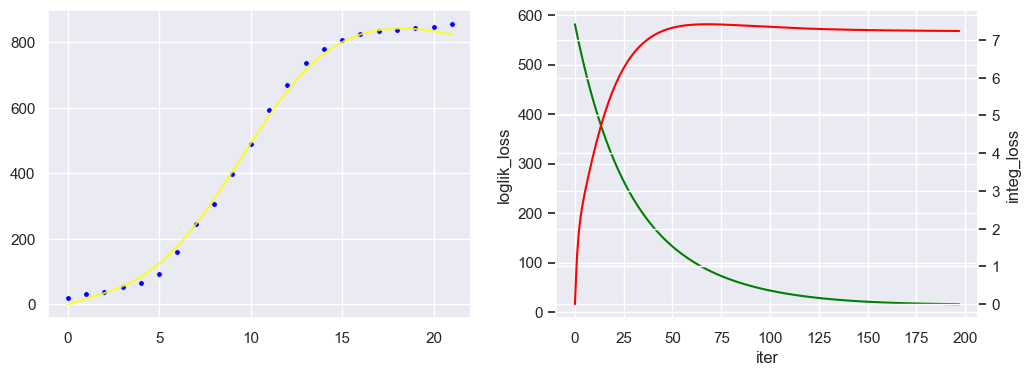

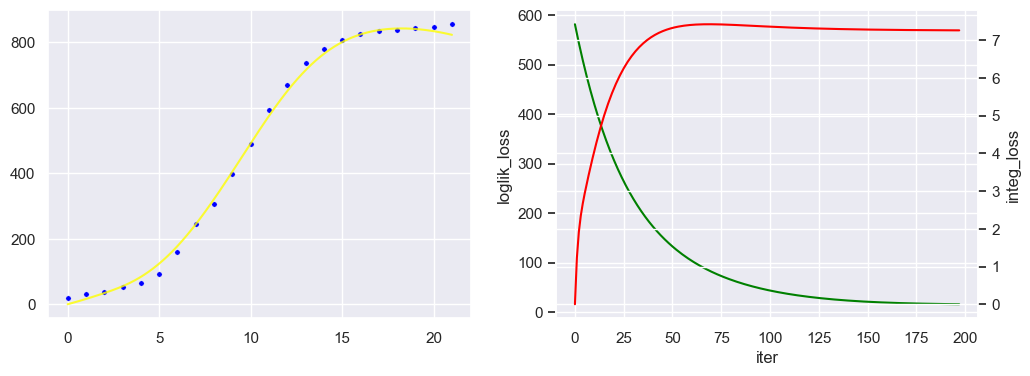

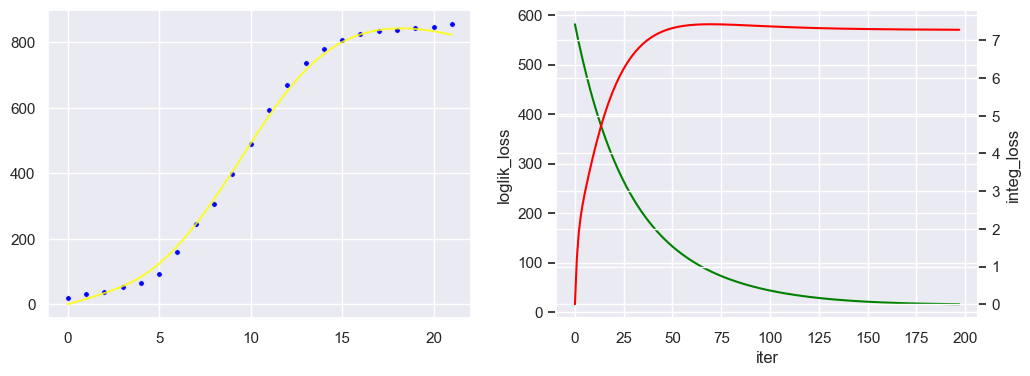

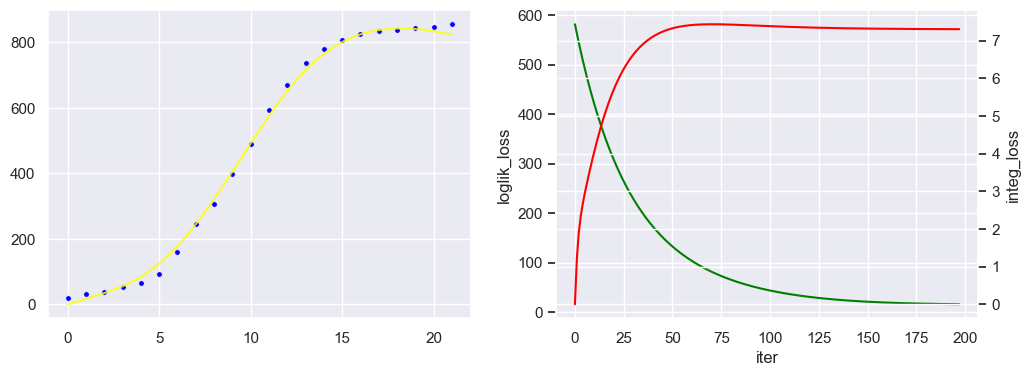

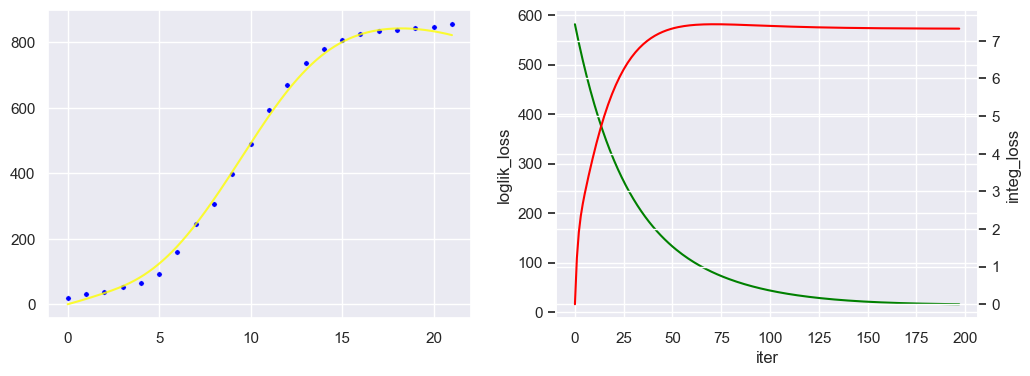

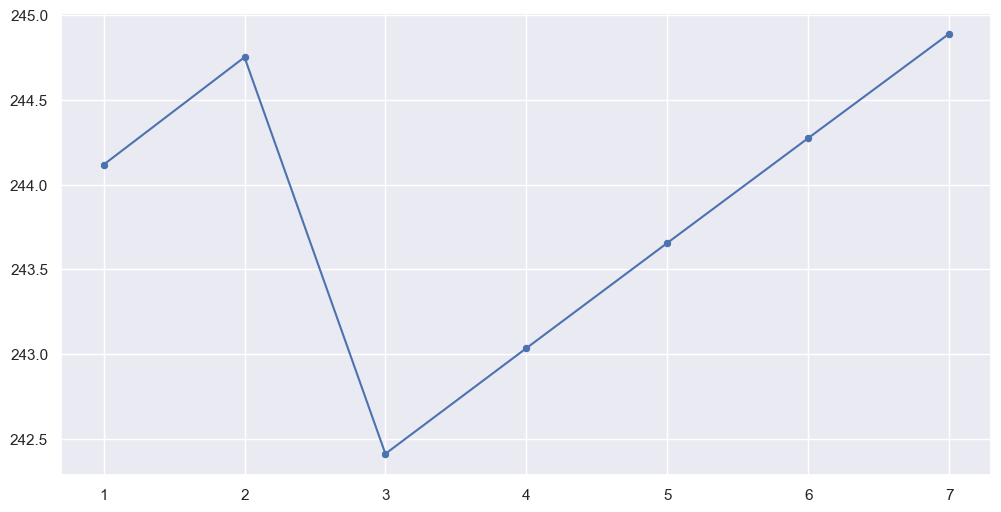

In [289]:
kappa_init, mu_init, tau_init = 0.70021195, 1.00693252, 1.2971215

theta_opt, losses, fitted_opt = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=200.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.01, 0.99),
    early_stop_ratio=[1.2, 0.999],
    early_stop_steps=3,
    show_process="both",
)

<AxesSubplot:>

<AxesSubplot:>

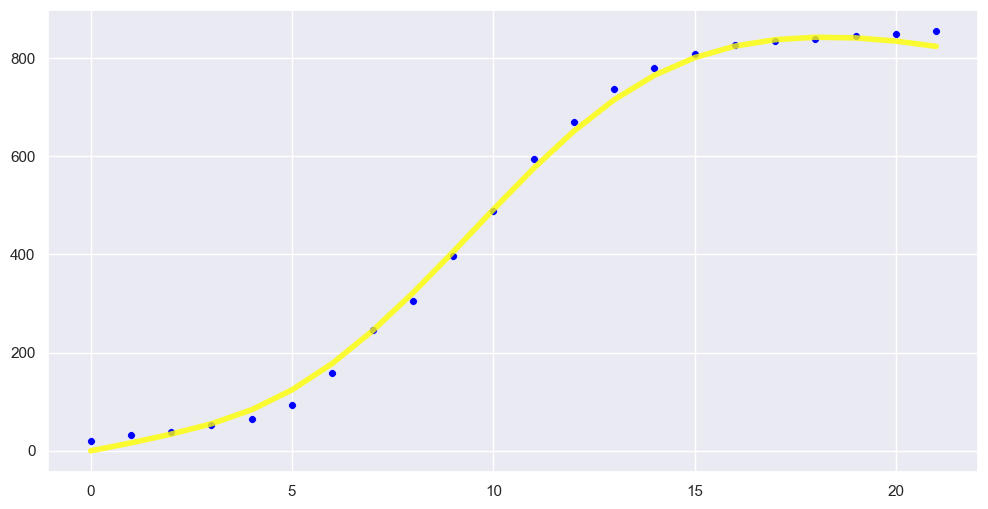

In [290]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(x=range(len(ser)), y=fitted_opt, alpha=0.8, color="yellow", linewidth=4)